In [1]:
import numpy as np
import astropy.units as u
from astropy.constants import c, m_p, k_B, h
#from scipy.special import expn
#from sympy import Symbol, uppergamma, lambdify
from agnpy.spectra import PowerLaw
import matplotlib.pyplot as plt
from agnpy.utils.math import axes_reshaper
from agnpy.spectra import ExpCutoffPowerLaw as ECPL
from agnpy.utils.conversion import epsilon_equivalency
from agnpy.photo_meson.kernels import phi_gamma

print(np. __version__)

1.25.1


### Reproduce Fig. 15 KA2008

The formulas we need are Eqs. 70-71 of the paper: $ \frac{dN}{dE} = \int_{\eta_{0}}^\infty H(\eta, E) \mathrm \, {d}\eta $, with $ H(\eta, E) = \int_{E}^\infty \frac{dE_p}{E_p^{2}} \, f_p(E_p) \, f_{ph} \left( \frac{\eta \, m_p^2 c^4}{4E_p} \right) \, \Phi_i\left(\eta, \frac{E}{E_p}\right) $

By putting them together we have: 
\begin{equation}
    \frac{dN}{dE} = \frac{m_p^2 \, c^4}{4} \int_{\eta_{0}}^\infty \mathrm \, {d}\eta \int_{E}^\infty \frac{dE_p}{E_p^{2}} \, f_p(E_p) \, f_{ph} \left( \frac{\eta \, m_p^2 c^4}{4E_p} \right) \, \Phi_i\left(\eta, \frac{E}{E_p}\right) 
    %\label{eq:dnde}
\end{equation}

Here $E$, the lower extreme of the integration, is varying. It represent the starting energy of the output particle and we need it to vary in order to build the spectrum on each energy bin.

In order to perform the integration with it varying we need a mask on the energy array (in our case the $\gamma$ array since AGNpy uses $\gamma$). Then we need to integrate over $\eta$.
In order to do all of this we need: 
- integrand to be 3D
- $H(\eta, E)$ to be 2D 
- $\mathrm{d}N/\mathrm{d}E$ to be 1D (it is our spectrum)

In order to compute the spectrum we then need the $\eta$ and $E$ arrays.
Since AGNpy works with the Lorentz factor $\gamma$ and not with energies, we have to convert the equation of $dN/dE$ in $\gamma$.

In this way the input array we give is the Lorentz factor $\gamma$ of the output particles. In case we are interested in the output $\gamma-$ rays, the $\gamma$ array represent the dimensionless energy of the photons, given by $\epsilon = \frac{h \nu}{m_p c^2}$

In [2]:
# Constants
mpc2 = (m_p * c ** 2).to('eV')

In [33]:
# Define arrays to integrate on
eta = np.linspace(0.3443,31.3,10)
eta0 = 0.313

Ec = 3 * 1e20 * u.eV
#Eg = 0.5 * Ec
Emax = 1e23 * u.eV
gamma_max = (Emax / mpc2).to_value("")
gamma_lim = (Ec / mpc2).to_value("") # it is the epsilon for photons
gamma = np.logspace(np.log10(gamma_lim), np.log10(gamma_max), 10)

# Conversion of variables in Eq. 70 into log
y = np.log10(gamma)
y_lim = np.log10(gamma_lim)
y_max = np.log10(gamma_max)

# Create matrix for integration with varying lower extreme
y_x, y_y = np.meshgrid(y, y)

# Reshape axes for multi-dimensionale operations
# _y_x, _y_y, _eta = axes_reshaper(y_x, y_y, eta) # first integral variable before
_y_x, _y_y, _eta = axes_reshaper(y, y, eta) # first integral variable before
# _y_x, _eta, _y_y, = axes_reshaper(y, eta, y) # first integral variable before

print(y.shape)
print(y_x.shape)
print(_y_x.shape)
print(_y_y.shape)
print(_eta.shape)

# plt.plot(y_x, y_y, marker='o',linestyle='none')


(10,)
(10, 10)
(10, 1, 1)
(1, 10, 1)
(1, 1, 10)


In [34]:
print(y_x)

[[11.50479246 11.78511232 12.06543218 12.34575204 12.6260719  12.90639176
  13.18671162 13.46703148 13.74735134 14.0276712 ]
 [11.50479246 11.78511232 12.06543218 12.34575204 12.6260719  12.90639176
  13.18671162 13.46703148 13.74735134 14.0276712 ]
 [11.50479246 11.78511232 12.06543218 12.34575204 12.6260719  12.90639176
  13.18671162 13.46703148 13.74735134 14.0276712 ]
 [11.50479246 11.78511232 12.06543218 12.34575204 12.6260719  12.90639176
  13.18671162 13.46703148 13.74735134 14.0276712 ]
 [11.50479246 11.78511232 12.06543218 12.34575204 12.6260719  12.90639176
  13.18671162 13.46703148 13.74735134 14.0276712 ]
 [11.50479246 11.78511232 12.06543218 12.34575204 12.6260719  12.90639176
  13.18671162 13.46703148 13.74735134 14.0276712 ]
 [11.50479246 11.78511232 12.06543218 12.34575204 12.6260719  12.90639176
  13.18671162 13.46703148 13.74735134 14.0276712 ]
 [11.50479246 11.78511232 12.06543218 12.34575204 12.6260719  12.90639176
  13.18671162 13.46703148 13.74735134 14.0276712 ]


In [35]:
# Proton distribution with alpha = 2
#k1 = 1 * u.eV
k1 = (0.24153*1e11)/(mpc2.value**2) * u.Unit('cm-3')
#k1 = 1e5 * u.Unit("cm-3")
p = 2.0

n_p = ECPL(k = k1, 
          p = p,
          gamma_c = gamma_lim,
          gamma_min = 1,
          gamma_max = 1e15, 
          mass = m_p)

In [36]:
# Soft photon distribution: Black Body
def BlackBody(epsilon):
    T = 2.7 * u.K
    kT = (k_B * T).to('eV').value
    c1 = c.to('cm s-1').value
    h1 = h.to('eV s').value
    norm = 8 * np.pi / (h1 ** 3 * c1 ** 3)
    num = (mpc2.value * epsilon) ** 2
    denom = np.exp(mpc2.value * epsilon / kT) - 1
    
    return norm * (num / denom) * u.Unit('cm-3')

In [37]:
# Create H integrand in log (from Eq. 70 KA2008)
fp_log = n_p(10 ** _y_x).value
fph_log = BlackBody(_eta / (4 * 10 ** _y_x)).value
phig_log = phi_gamma(_eta, 10 ** y_lim/ 10 ** _y_x)

H_integrand_log = (10 ** (-_y_x)) * fp_log * fph_log * phig_log * np.log(10)

print(fp_log.shape)
print(fph_log.shape)
print(phig_log.shape)
print(H_integrand_log.shape)
print(_y_x.shape)
print(_eta.shape)
# print(_y_x)
# print(_eta)

(10, 1, 1)
(10, 1, 10)
(10, 1, 10)
(10, 1, 10)
(10, 1, 1)
(1, 1, 10)


(10, 10, 10)
(10, 10, 1)
[[[ True]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]]

 [[ True]
  [ True]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]]

 [[ True]
  [ True]
  [ True]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [False]
  [False]
  [False]
  [False]
  [False]
  [False]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [False]
  [False]
  [False]
  [False]
  [False]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [False]
  [False]
  [False]
  [False]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [False]
  [False]
  [False]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [False]
  [False]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [False]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [ True]
  [ Tru

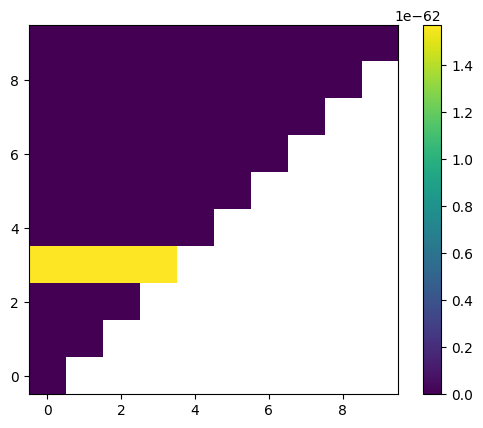

In [40]:
# Create mask in order to integrate with varying lower extreme
mask = _y_x >= _y_y
# mask = y_x >= y_y
H_integrand_masked = np.where(mask, H_integrand_log, 0)

H_int_masked = np.where(mask, H_integrand_log, np.nan)

# #print(H_integrand_masked)
print(H_integrand_masked.shape)
print(mask.shape)
print(mask)

fig, ax = plt.subplots()
im = ax.imshow(H_int_masked[:,:,0], origin="lower")
fig.colorbar(im)

In [41]:
# Compute first integration (on gammas)
prefactor = mpc2 / 4
H = np.trapz(prefactor * H_integrand_masked, _y_x, axis=0)

#print(H)
print(H.shape)
print(_y_x.shape)
print(_y_y.shape)

(10, 10)
(10, 1, 1)
(1, 10, 1)


In [46]:
# Compute second integration (on etas)
dNdE = np.trapz(H, eta, axis=0)
#dNdE = np.trapz(H, _eta, axis=0)
# dNdE = (dNdE * u.Unit('eV-1 cm-3 s-1')).to('erg-1 cm-3 s-1')

#print(dNdE)
print(dNdE.shape)
print(H.shape)
print(_eta.shape)
print(eta.shape)

print(_y_x[:,0])

# dNdE = np.trapz(H, eta, axis=0)

(10,)
(10, 10)
(1, 1, 10)
(10,)
[[11.50479246]
 [11.78511232]
 [12.06543218]
 [12.34575204]
 [12.6260719 ]
 [12.90639176]
 [13.18671162]
 [13.46703148]
 [13.74735134]
 [14.0276712 ]]


(1e+17, 5e+23)

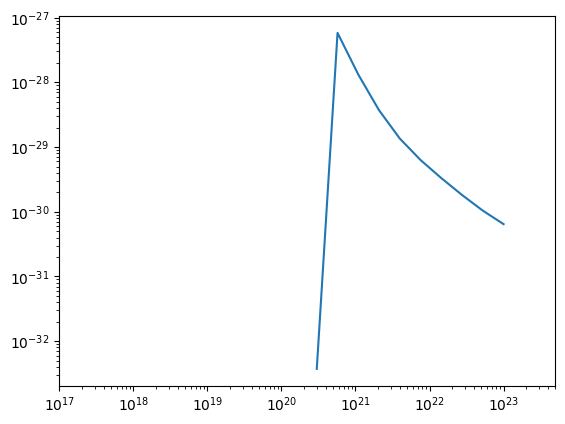

In [49]:
E = gamma * mpc2
plt.loglog(E, E * dNdE)
# plt.xlabel(r'$\eta / \eta_0$')
# plt.ylabel(r'$H(\eta, E_\gamma)$')
# plt.ylim(1e-39,1e-36)
plt.xlim(1e17,5e23)